In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy
import sys
import os
project_path = os.path.expanduser('~/repos/laplace_operator_metric_graph/')
sys.path.append(project_path)
import construct_graph
import solve_laplace_operator
from helper_functions import style_plot, sequential_Newton

%load_ext autoreload
%autoreload 2

#### Load eigenvalues

In [2]:
with open("../data/random_delaunay_torus_eigenvalues.pkl", "rb") as file:
    torus_eigenvalues = pickle.load(file)
with open("../data/random_delaunay_sphere_eigenvalues.pkl", "rb") as file:
    sphere_eigenvalues = pickle.load(file)

#### Verify that calculated eigenvalues match loaded values

In [3]:
num_Vs = 1000
seed = 0
gtype = "sphere"

np.random.seed(seed)

if gtype == "torus":
    g = construct_graph.patch_graph.Random_Delaunay(num_Vs)
    g = construct_graph.patch_graph.Patch(g)
    eig_set = torus_eigenvalues.copy()
    guesses = np.linspace(3.9, 4.6, 30)
elif gtype == "sphere":
    g = construct_graph.random_delaunay_sphere.Random_Delaunay_Sphere(num_Vs)
    eig_set = sphere_eigenvalues.copy()
    guesses = np.linspace(0.9, 1.1, 30)

eigs = solve_laplace_operator.solve_laplace_operator.Eigenvalue_Calculator(g)
full_solutions = sequential_Newton(guesses, eigs, min_eigenvalue=0, max_eigenvalue=10)
eigenvalue_data = full_solutions.copy()

print()
print(f"calculated eigenvalues \t\t = {eigenvalue_data}")
print(f"eigenvalues from loaded data \t = {eig_set[num_Vs][seed]}")


Calculating eig number 0

----------------------
Converged at step 1:

k = 0.9389150777342424
----------------------

Calculating eig number 1

----------------------
Converged at step 1:

k = 0.9480798867656897
----------------------

Calculating eig number 2

----------------------
Converged at step 2:

k = 0.9762548155669046
----------------------

calculated eigenvalues 		 = [0.93891508 0.94807989 0.97625482]
eigenvalues from loaded data 	 = [0.93891508 0.94807989 0.97625482]


#### Load relative errors for eigenvalues/functions 

In [4]:
with open("../data/random_delaunay_eigenmode_rel_errs.pkl", "rb") as file:
    rel_errs = pickle.load(file)

In [5]:
problems = ["square_flat_torus", "sphere"]
graph_type = "random_delaunay"
mn = [[0, 1], [1, 1]]

if gtype == "torus":
    m, n = mn[0]
    problem = problems[0]
    p = solve_laplace_operator.solve_laplace_operator_update.Projector(g, m, n, torus_eigenvalues[num_Vs][seed], problem, graph_type)
elif gtype == "sphere":
    m, n = mn[1]
    problem = problems[1]
    p = solve_laplace_operator.solve_laplace_operator_update.Projector(g, m, n, sphere_eigenvalues[num_Vs][seed], problem, graph_type)

print(f"Eigenvalue relative errors \t\t = {p.data[0]}")
print(f"Eigenvalue relative errors loaded \t = {rel_errs[gtype][num_Vs]['eigenvalues'][seed]}")
print(f"Eigenfunction relative errors \t\t = {p.data[1]}")
print(f"Eigenfunction relative errors loaded \t = {rel_errs[gtype][num_Vs]['eigenfunctions'][seed]}")

Eigenvalue relative errors 		 = [0.04191063 0.0231154  0.03580922]
Eigenvalue relative errors loaded 	 = [0.04191063 0.0231154  0.03580922]
Eigenfunction relative errors 		 = [0.07652155 0.07392547 0.07051051]
Eigenfunction relative errors loaded 	 = [0.07652155 0.07392547 0.07051051]


#### Plot modes

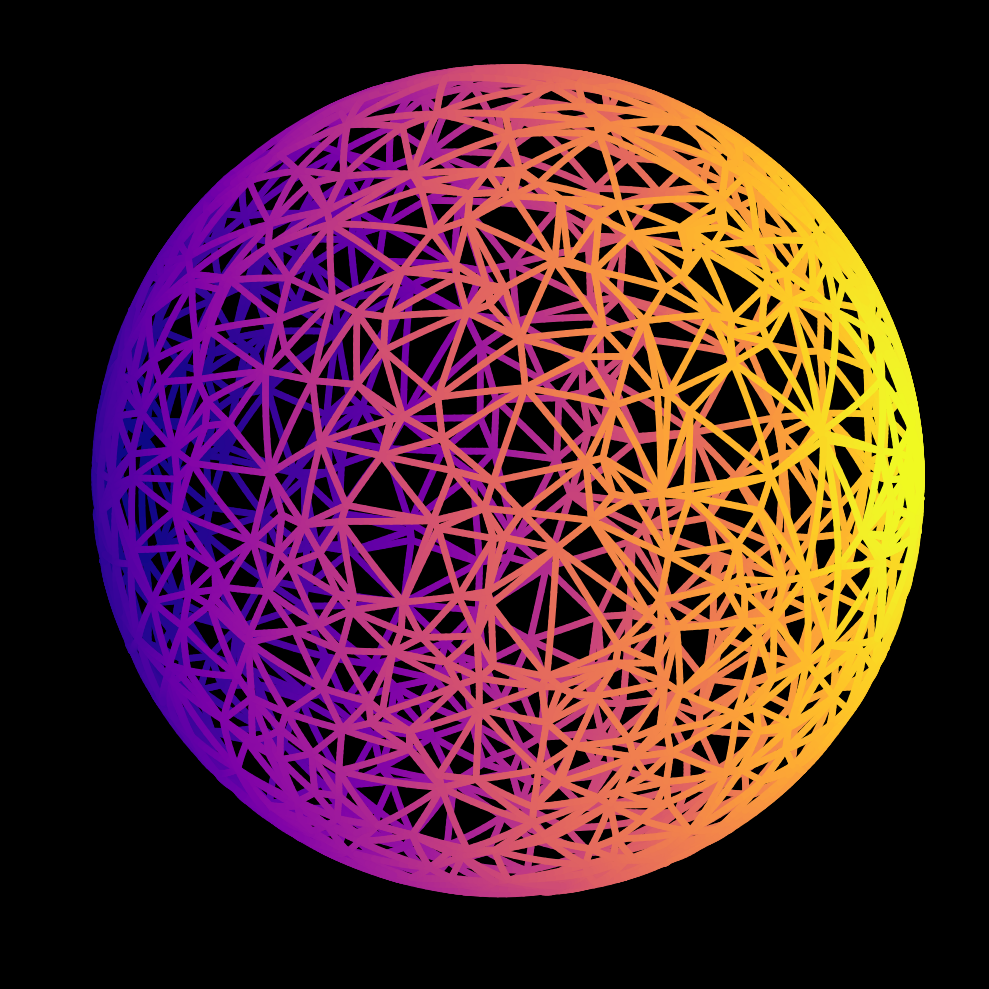

In [6]:
mode_number = 1
g.plot_graph(eigenmode=p.graph_eigenfunctions[mode_number].data, background_color="black", figsize=10)

#### Set up data for plotting

In [7]:
torus_nums_Vs = np.array(list(rel_errs["square_flat_torus"].keys()))
sphere_nums_Vs = np.array(list(rel_errs["sphere"].keys()))

all_nums_Vs = [torus_nums_Vs, sphere_nums_Vs]

rel_errs_plot_data = {"eigenvalues": {}, "eigenfunctions": {}}
for graph in rel_errs:
    rel_errs_plot_data["eigenvalues"][graph] = {"mean": [], "error_upper": [], "error_lower": []}
    rel_errs_plot_data["eigenfunctions"][graph] = {"mean": [], "error_upper": [], "error_lower": []}

    for data_type in ["eigenvalues", "eigenfunctions"]:

        for data in rel_errs[graph].values():

            data_type_data = np.array(data[data_type])

            means = np.mean(data_type_data)
            stds = np.std(data_type_data)
            y_ratio_upper = means * (1 + stds / means)  
            y_ratio_lower = means / (1 + stds / means)
            error_upper = y_ratio_upper - means
            error_lower = means - y_ratio_lower

            rel_errs_plot_data[data_type][graph]["mean"].append(means)
            rel_errs_plot_data[data_type][graph]["error_upper"].append(error_upper)
            rel_errs_plot_data[data_type][graph]["error_lower"].append(error_lower)

        rel_errs_plot_data[data_type][graph]["mean"] = np.array(rel_errs_plot_data[data_type][graph]["mean"])
        rel_errs_plot_data[data_type][graph]["error_upper"] = np.array(rel_errs_plot_data[data_type][graph]["error_upper"])
        rel_errs_plot_data[data_type][graph]["error_lower"] = np.array(rel_errs_plot_data[data_type][graph]["error_lower"])

#### Plot

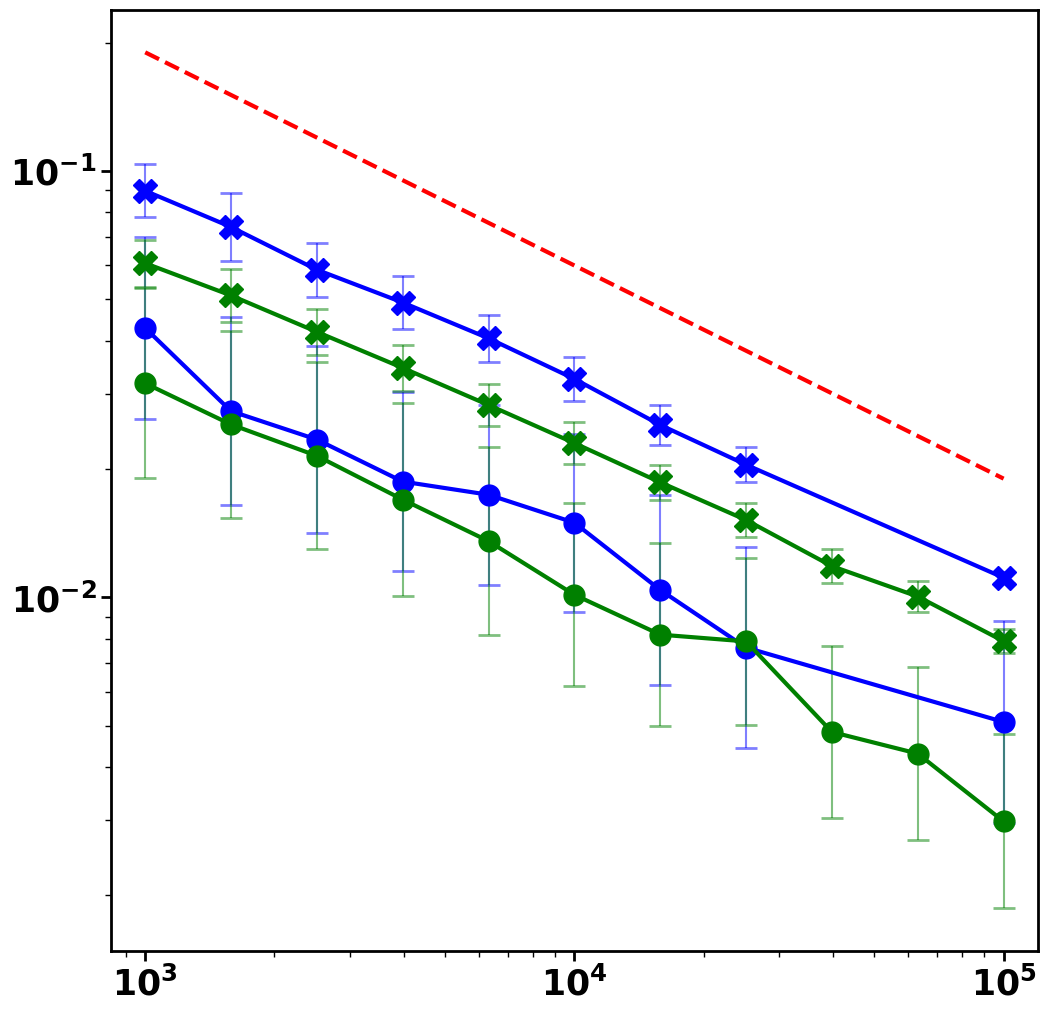

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

colors = ["b", "g", "purple"]
eigenvalue_linewidth = 3
eigenvalue_markersize = 15
markers = ["o", "X"]
ms = [eigenvalue_markersize, eigenvalue_markersize*1.15]

for data_en, data_type in enumerate(rel_errs_plot_data):

    for en, problem in enumerate(rel_errs_plot_data[data_type]):

        ax.loglog(all_nums_Vs[en], rel_errs_plot_data[data_type][problem]["mean"], 
                  f'{markers[data_en]}-', c=colors[en], linewidth=eigenvalue_linewidth, markersize=ms[data_en])

        ax.errorbar(all_nums_Vs[en], rel_errs_plot_data[data_type][problem]["mean"], 
                    yerr=[rel_errs_plot_data[data_type][problem]["error_lower"], 
                          rel_errs_plot_data[data_type][problem]["error_upper"]], 
                    capsize=8, capthick=2, c=colors[en], alpha=0.5, zorder=0)

ax.loglog(np.linspace(1000, 100000, 2), np.linspace(1000, 100000, 2)**(-0.5) * 6, 
        '--', c="r", linewidth=eigenvalue_linewidth, markersize=eigenvalue_markersize)

x_min, x_max = all_nums_Vs[en].min(), all_nums_Vs[en].max()
ax.set_xlim(10**(np.log10(x_min) - 0.08), 10**(np.log10(x_max) + 0.08))

style_plot(fig, ax, aspect=None)